# Examples of XAI-Lib Usage for MNIST data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## Intgrad (Tensorflow Model)

<img src='./images/intgrad_MNIST.jpg' width="20%" height="20%">

In [2]:
# Load Dataset
from tensorflow.keras.datasets import mnist
(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()
#MNIST_x_data_train = np.load('./datasets/mnist_x_train.npy')
#MNIST_y_data_train = np.load('./datasets/mnist_y_train.npy')
#MNIST_x_data_test = np.load('./datasets/mnist_x_test.npy')
#MNIST_y_data_test = np.load('./datasets/mnist_y_test.npy')

# Load the model
import tensorflow as tf
assert tf.__version__[0]=='2', 'please install tensorflow 2.x'
MNIST_CNN_tf = tf.keras.models.load_model('./models/keras_cnn_mnist')
MNIST_CNN_tf.trainable=False
MNIST_CNN_tf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

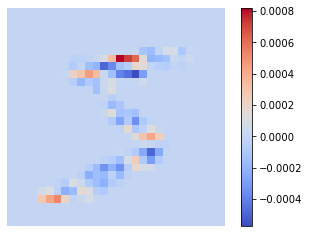

In [4]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer

# 1) Create the Explainer
ig = IntgradImageExplainer(MNIST_CNN_tf)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
image = MNIST_x_data_train[0,:]

# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return tf.convert_to_tensor(image.reshape(28,28,1),dtype=tf.float32)

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return tf.nn.softmax(MNIST_CNN_tf(image), axis=-1)

# 5) Explain an Instance
tf_scores = ig.explain(image, 5, 'black', preprocessing, predict, model_type='tensorflow')

plt.imshow(tf_scores,cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## Intgrad (PyTorch Model)

In [5]:
# Load Dataset
#import torchvision
#import torchvision.datasets as datasets
#mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
#mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)
#from tensorflow.keras.datasets import mnist
#(MNIST_x_data_train, MNIST_y_data_train), (MNIST_x_data_test, MNIST_y_data_test) = mnist.load_data()

# Load the model
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = torch.nn.functional.softmax(self.linear_block(x),dim=1)
        
        return x
MNIST_CNN = Net()
MNIST_CNN.load_state_dict(torch.load('./models/MNIST_Pytorch_CNN.pt',map_location=torch.device('cpu')))
MNIST_CNN.eval()

Net(
  (conv_block): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=6272, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

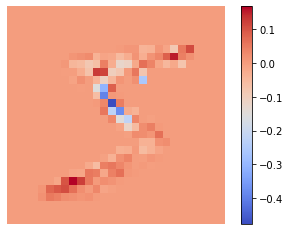

In [6]:
from xailib.explainers.intgrad_explainer import IntgradImageExplainer
from skimage.color import gray2rgb

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

# 1) Create the Explainer
ig = IntgradImageExplainer(MNIST_CNN)

# 2) Fit the Explainer
ig.fit()

# 3) Select the image we want to give an explanation for
image = MNIST_x_data_train[0]

# 4a) Preprocessing function: function that takes as input an image and return the correct format for the black box
def preprocessing(image):
    return torch.tensor([[image]]).float()

# 4b) Predict Function of our black box: It needs to take as input the output of preprocessing and return an array of probabilities of classes with shape (-1,num_classes)
def predict(image):
    return MNIST_CNN(image)

# 5) Explain an Instance
scores = ig.explain(image, 5, 'black', preprocessing, predict, model_type='pytorch')

plt.imshow(scores,cmap='coolwarm')
plt.colorbar()
plt.axis('off');

## LIME

<img src='./images/lime_MNIST.jpg' width="50%" height="50%">

100%|██████████| 500/500 [00:00<00:00, 564.68it/s]


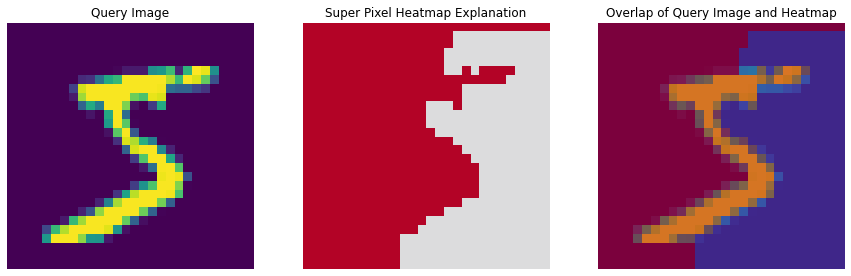

In [7]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# index of the image to explain
idx = 0

# 1) Create the Explainer
lm = LimeXAIImageExplainer(MNIST_CNN)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images).reshape(-1,1,28,28)).float()
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(gray2rgb(MNIST_x_data_train[idx]), classifier_fn, num_samples=500)

# 4) Plot the results
lm.plot_lime_values(MNIST_x_data_train[idx], explanation)

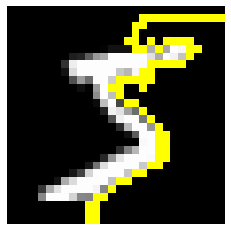

In [8]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)
plt.axis('off');

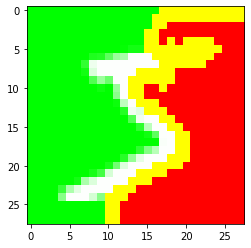

In [9]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2);

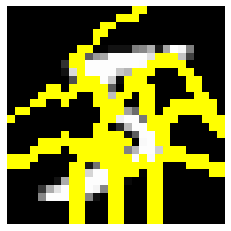

In [10]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = gray2rgb(MNIST_x_data_train[0].astype(int))
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=2, max_dist=3)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

100%|██████████| 500/500 [00:00<00:00, 528.77it/s]


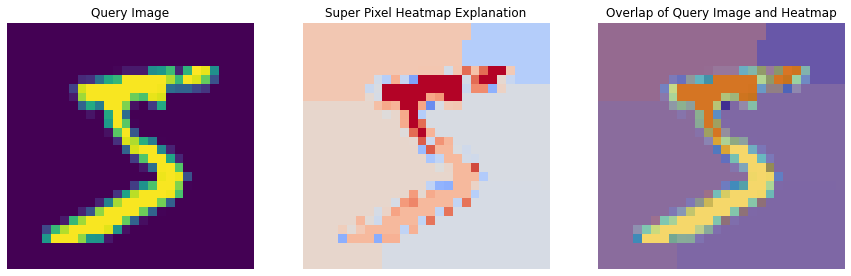

In [11]:
from xailib.explainers.lime_explainer import LimeXAIImageExplainer
from skimage.color import label2rgb, gray2rgb, rgb2gray

# index of the image to explain
idx = 0

# 1) Create the Explainer
lm = LimeXAIImageExplainer(MNIST_CNN)

# 2a) Fit the Explainer
lm.fit()

# 2b) Create custom classifier function if not predict 
# function that takes as input an array of images (the LIME neighbourhood) and return an array of (num_images,num_classes)
# If None will use black_box.predict function
def classifier_fn(images):
    images = torch.tensor(rgb2gray(images).reshape(-1,1,28,28)).float()
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# 3) Explain an Instance
explanation = lm.explain(gray2rgb(MNIST_x_data_train[idx]), classifier_fn, segmentation_fn, num_samples=500)

# 4) Plot the results
lm.plot_lime_values(MNIST_x_data_train[idx], explanation)

## RISE

<img src='./images/rise_MNIST.jpg' width="50%" height="50%">

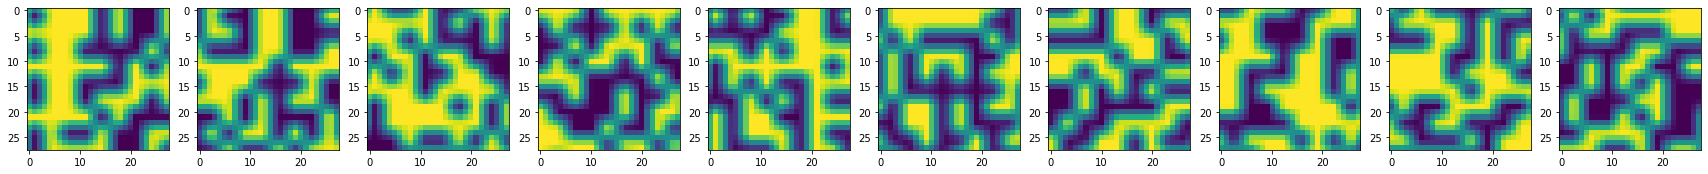

In [12]:
from xailib.explainers.rise_explainer import RiseXAIImageExplainer

class Rise_model_wrapper():
    def __init__(self, bb, input_size):
        self.model = bb
        self.input_size = input_size
        
    def predict(self, X):
        return self.model(torch.tensor(X).reshape(-1,1,28,28).float()).detach().numpy()
        

model = Rise_model_wrapper(MNIST_CNN, (28,28))
rise = RiseXAIImageExplainer(model)
        

N = 10 # number of random masks
s = 10 # cell_size = input_shape / s
p1 = 0.5 # masking probability

rise.fit(N, s, p1)

F,ax=plt.subplots(1,10,figsize=(30,5))
for i in range(10):
    ax[i].imshow(rise.masks[i,:])

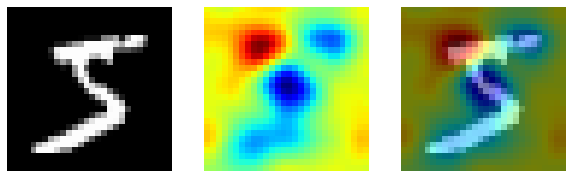

In [13]:
fig, ax = plt.subplots(1,3,figsize=(10,5))
img = MNIST_x_data_train[0,:]
N = 4000
s = 8
p1 = 0.5

rise.fit(N, s, p1)

sal = rise.explain(img.reshape(28,28,1)/255)

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(sal[MNIST_y_data_test[0]],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(sal[MNIST_y_data_test[0]],cmap='jet',alpha=0.5)
ax[2].axis('off');

# GRADCAM
Weight the 2D activations by the average gradient

In [14]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer

img = MNIST_x_data_train[0,:]

explainer = GradCAMImageExplainer(MNIST_CNN)

explainer.fit([MNIST_CNN.conv_block[10]])

attr = explainer.explain(torch.tensor(img).reshape(-1,1,28,28).float()/255, 5, model_type='pytorch')

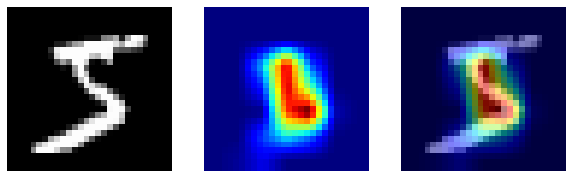

In [15]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

In [16]:
from xailib.explainers.gradcam_explainer import GradCAMImageExplainer

img = MNIST_x_data_train[0,:]

explainer = GradCAMImageExplainer(MNIST_CNN_tf)

explainer.fit('max_pooling2d_1', model_type='tensorflow')

attr = explainer.explain(tf.convert_to_tensor(img.reshape(28,28,1)/255,dtype=tf.float32), 5, model_type='tensorflow')

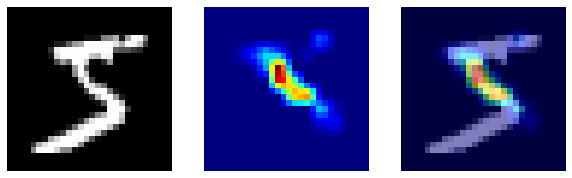

In [17]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr,cmap='jet',alpha=0.5)
ax[2].axis('off');

# GRADCAM++
Like GradCAM but uses second order gradients

In [18]:
from xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

img = MNIST_x_data_train[0,:]

explainer = GradCAMPlusPlusImageExplainer(MNIST_CNN)

explainer.fit([MNIST_CNN.conv_block[10]])

attr = explainer.explain(torch.tensor(img).reshape(-1,1,28,28).float()/255, 5, model_type='pytorch')

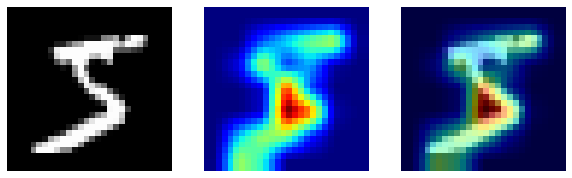

In [19]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr[0,:],cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr[0,:],cmap='jet',alpha=0.5)
ax[2].axis('off');

In [20]:
from xailib.explainers.gradcam_explainer import GradCAMPlusPlusImageExplainer

img = MNIST_x_data_train[0,:]

explainer = GradCAMPlusPlusImageExplainer(MNIST_CNN_tf)

explainer.fit('max_pooling2d_1', model_type='tensorflow')

attr = explainer.explain(tf.convert_to_tensor(img.reshape(28,28,1)/255,dtype=tf.float32), 5, model_type='tensorflow')

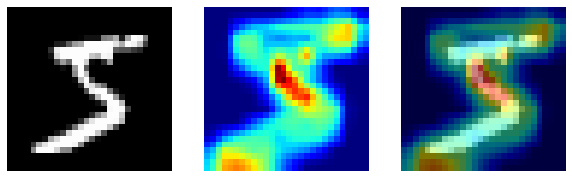

In [21]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].imshow(img,cmap='gray')
ax[0].axis('off')

ax[1].imshow(attr,cmap='jet')
ax[1].axis('off')

ax[2].imshow(img,cmap='gray')
ax[2].imshow(attr,cmap='jet',alpha=0.5)
ax[2].axis('off');

# ILORE

<img src='./images/lore_MNIST.jpg' width="50%" height="50%">

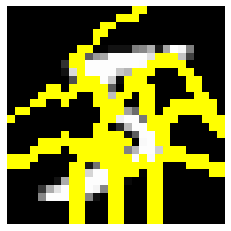

In [22]:
from skimage.segmentation import quickshift, mark_boundaries
from skimage.color import gray2rgb
image = gray2rgb(MNIST_x_data_train[0].astype(int))
"""
First you need to define the segmentation function to use, in this example we will use
quickshift from skimage. It is foundamental to tune the parameters of the segmentation in
order to have a good one. It is recommentded to print an example of just only the segmentation
to see if it works for that kind of image
For quickshift we have to tune these two parameters below
kernel_size : float, optional
    Width of Gaussian kernel used in smoothing the
    sample density. Higher means fewer clusters.
max_dist : float, optional
    Cut-off point for data distances.
    Higher means fewer clusters.
"""
def segmentation_fn(image):
    return quickshift(image, kernel_size=2, max_dist=3)
plt.imshow(mark_boundaries(image/255,segmentation_fn(image)))
plt.axis('off');

In [23]:
from externals.LOREM.ilorem import ILOREM

# Function to convert from rgb2gray since the one implemented in skimage gives problems
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

# Predict Function of our black box. 
# !!!IMPORTANT!!! It needs to take as input a list of RGB images and return an array of class indices of shape (-1,1)
def classifier_fn(images):
    images = torch.tensor(rgb2gray(np.array(images))/255).float().unsqueeze(1)
    return np.argmax(MNIST_CNN(images).detach().numpy(),axis=1).reshape(-1,1)

# Create the explainer
explainer = ILOREM(bb_predict = classifier_fn, 
                   class_name='class', 
                   class_values = range(10), 
                   segmentation_fn=segmentation_fn,
                   verbose=True)

In [24]:
exp = explainer.explain_instance(gray2rgb(MNIST_x_data_train[0].astype(int)), num_samples=100, use_weights=True, metric='cosine')

generating neighborhood
synthetic neighborhood class counts {3: 37, 5: 59, 7: 1, 8: 1, 9: 2}
learning local decision tree
retrieving explanation


In [25]:
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.rstr(), exp.cstr()))

e = {
	r = { 1 > 0.50, 5 > 0.50 } --> { class: 5 }
	c = { { 1 <= 0.50 } --> { class: 3 } }    
}


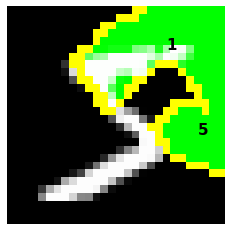

In [26]:
x,y = np.meshgrid(range(28),range(28))
img2show, mask = exp.get_image_rule(hide_rest=False, num_features=None, min_importance=0.0)
plt.imshow(mark_boundaries(img2show/255,mask))
mask[mask != 2] = -1
mask[mask == 2] = segmentation_fn(image)[mask == 2]

mask = mask.ravel()

for i in np.unique(mask):
    if i != -1:
        x_c = x.ravel()[np.where(mask==i)[0]]
        y_c = y.ravel()[np.where(mask==i)[0]]
        plt.text(np.median(x_c),np.median(y_c),str(i),fontsize=15, weight='bold')
plt.axis('off');

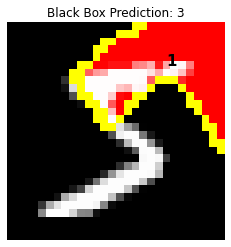

In [27]:
imgs2show, masks, coutcomes = exp.get_image_counterfactuals(hide_rest=False, num_features=None, min_importance=0.0)
x,y = np.meshgrid(range(28),range(28))
s = segmentation_fn(image)

if len(imgs2show)==1:
    plt.imshow(mark_boundaries(imgs2show[0]/255, masks[0]))
    
    mask = masks[0]
    mask[mask != 1] = -1
    mask[mask == 1] = s[mask == 1]
    mask = mask.ravel()
    for j in np.unique(mask):
        if j != -1:
            x_c = x.ravel()[np.where(mask==j)[0]]
            y_c = y.ravel()[np.where(mask==j)[0]]
            plt.text(np.median(x_c),np.median(y_c),str(j),fontsize=15, weight='bold')
            
    plt.title('Black Box Prediction: '+str(coutcomes[0]))
    plt.axis('off')
else:
    F, ax = plt.subplots(1,len(imgs2show),figsize=(5*len(imgs2show),5))
    for i in range(len(imgs2show)):
        ax[i].imshow(mark_boundaries(imgs2show[i]/255, masks[i]))
        
        mask = masks[i]
        mask[mask != 1] = -1
        mask[mask == 1] = s[mask == 1]
        mask = mask.ravel()
        for j in np.unique(mask):
            if j != -1:
                x_c = x.ravel()[np.where(mask==j)[0]]
                y_c = y.ravel()[np.where(mask==j)[0]]
                ax[i].text(np.median(x_c),np.median(y_c),str(j),fontsize=15, weight='bold')
        
        ax[i].set_title('Black Box Prediction: '+str(coutcomes[i]))
        ax[i].axis('off')

# ABELE

In order to work ABELE needs a Test Set and an autoencoder trained on that

### 1) Autoencoder Training

Here we have a script to guide the user to the creation and the training of the autoencoder. 
If you want to use your own, you need to implement an autoencoder class with these funtioncs inside:
- self.encode: take the image as input and return the latent space vector
- self.decode: take a vector as input and return the reconstructed image
- self.latent_dim: int representing the number of dimensions of the latent space
- self.discriminator: (only for adversarial autoencoders) take a vector as input and output a class label

In [28]:
import sys
import os
import skimage
from externals.ABELE.experiments.exputil import get_autoencoder
from externals.ABELE.experiments.exputil import get_dataset
import shap
import warnings
warnings.filterwarnings('ignore')

#disable eager execution in tensorflow 2.x for faster training time
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# The dataset to use for training
# if you prefer to use yours load the data in two vector X_data and Y_data, set dataset variable to a custom name and custom_dataset to True
dataset = 'mnist'
custom_dataset = False
if not custom_dataset:
    _, _, X_test, Y_test, use_rgb = get_dataset(dataset)

# The type of autoencoder to train ['aae','vae']
ae_name = 'aae'

# This script will save the models weights in the folder ./path/models/abele/dataset/ae_name
path = './'
path_aemodels = path + 'models/abele/%s/%s/' % (dataset,ae_name)
if not os.path.exists(path_aemodels):
    os.makedirs(path_aemodels)

# HYPER-PARAMETERS
#define the epochs and the batch size for which the autoencoder will be trained
epochs = 2000
batch_size = 64
#Print training summary every sample_interval step
sample_interval = 50

"""
 Get_autoencoder create the autoencoder class to train
 Arguments: 
    X: dataset to use to train the ae 
    ae_name: type of the autoencoder to train, only adversarial autoencoder (aae) and variational autoencoder (vae) are supported
    path_aemodels: path where to save the weights
    dataset: name of the dataset to use
    OPTIONAL:
    latent_dim: latent space dimension (only use if dataset is custom)
    hidden_dim: hidden dimension of the autoencoders layers (ex: 1024 will create two layers of 1024 hidden units) (only use if dataset is custom)
    num_filters: number of filter to use in the convolutional layers (only use if dataset is custom)
"""
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset)

""" Fit method
 Arguments: 
    X: Dataset to use to train the ae
    epochs: Epochs to train
    batch_size
    sample interval (see before)
"""
ae.fit(X_test, epochs=epochs, batch_size=batch_size, sample_interval=sample_interval)
# save the weights in the oath specified before
ae.save_model()
# save also some sample images to test if the autoencoderis trained correctly
ae.sample_images(epochs)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              5120      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 530,433
Trainable params: 530,433
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
__________________________________________________________________________________________________


In [31]:
ae.load_model()

generating neighborhood - hrg
gen	nevals	avg     	min     	max     
0  	75    	0.496654	0.496654	0.496654
1  	48    	0.501804	0.302764	0.992671
2  	53    	0.514133	0.231863	0.993288
3  	34    	0.570852	0.0176818	0.993288
4  	43    	0.718194	0.197294 	0.993288
5  	55    	0.821874	0.082482 	0.993288
6  	28    	0.951326	0.384237 	0.993288
7  	37    	0.955136	0.159815 	0.993288
8  	46    	0.923749	0.382577 	0.993288
9  	46    	0.953556	0.0133889	0.993288
10 	40    	0.949002	0.294277 	0.993292
11 	46    	0.963497	0.363209 	0.993292
12 	43    	0.965941	0.449077 	0.993292
13 	42    	0.946406	0.06759  	0.993304
14 	44    	0.950769	0.384703 	0.993304
15 	42    	0.966072	0.472228 	0.993304
16 	42    	0.919047	0.0135492	0.993304
17 	46    	0.944064	0.406801 	0.993304
18 	52    	0.953206	0.481242 	0.993304
19 	45    	0.957693	0.308688 	0.993304
20 	42    	0.95331 	0.485592 	0.993304
21 	44    	0.966811	0.49306  	0.993304
22 	39    	0.970943	0.317409 	0.993304
23 	47    	0.975504	0.252405 	0.993304

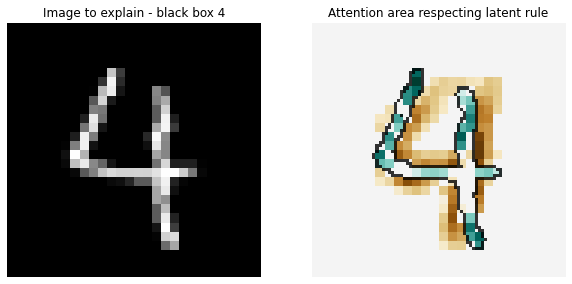

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from skimage.color import gray2rgb, rgb2gray
from skimage import feature, transform

from xailib.explainers.abele_explainer import ABELEImageExplainer
from externals.ABELE.experiments.exputil import get_dataset
from externals.ABELE.experiments.exputil import get_autoencoder

import warnings
warnings.filterwarnings('ignore')

random_state = 0
dataset = 'mnist' 
black_box = 'AB' #agnostic Black Box

# load autoencoder and black box
ae_name = 'aae' 
path = './' 
path_aemodels = path + 'models/abele/%s/%s/' % (dataset, ae_name)
bb = tf.keras.models.load_model("./models/cnn_simple_mnist_no_pickle")

# defining a functions for bb to return the class index value
def bb_predict(X):
    X = X.astype(float)
    Y = bb.predict(rgb2gray(X).reshape(-1,28,28,1))   
    return np.argmax(Y, axis=1)

# load data
_, _, X_test, Y_test, _ = get_dataset(dataset)

# load auto encoder
ae = get_autoencoder(X_test, ae_name, path_aemodels, dataset)
ae.load_model()

# index Image 2 Explain
i2e = 24
img = X_test[i2e]
# time
start = time.time()

# create explainer
"""
Arguments:
    bb_predict: function which return the prediction of the blackbox in form index of the class 
    class_name: name of the class used when printing rules (class_name: class_value)
    class_values: list of names of the classes (class_name: class_value)
    neigh_type: select the nighbourhood type,
                supportecd types:
                'gnt' : genetic
                'rnd' : random
                'hrg' : hybrid-random-genetic
                'gntp': genetic probabilistic
                'hrgp': hybrid probabilistic
    ocr: [0.1] other class values, ratio of other class from the one predicted in the neighbourhood
    kernel: [None] Kernel to weights the point in the nieghbourhood
    kernel_width : [None]  
    autoencoder: Autoencoder to generate the latent space points
    use_rgb = [True] Set to True if the input images are rgb, False for grayscale
    filter_crules: [None] if True Prototypes are checked by the black box to be the same class of the query image
    random_state: set the seed of the random state
    verbose: True if you want to print more informations
    NEIGHBOURHOOD PARAMETERS: the following parameters are Neighbourhood specific and may not apply to all of the neighbourhood types
        valid_thr: [0.5] threshold to change class in the autoencoder disciminator
        alpha1: [0.5] weight of the feature similarity of the neighbourhood points
        alpha2: [0.5] weight of the target similarity of the neighbourhood points
        ngen: [100] number of generations of the genetic algorithm
        mutpb: [0.2] The probability of mutating an individual in the genetic algorithm
        cxpb: [0.5] The probability of mating two individuals in the genetic algorithm
        tournsize: [3] number of tournaments in the genetic algorithm
        hallooffame_ratio: [0.1] Fraction of exemplars to keep at every genetic generation
"""
config = {'bb_predict':bb_predict,
          'class_name':'class',
          'class_values':['%s' % i for i in range(len(np.unique(Y_test)))],
          'neigh_type':'hrg', 
          'ocr':0.1, #other class ratio in the neighbourhood
          'kernel_width':None, 
          'kernel':None, 
          'autoencoder':ae, 
          'use_rgb':True, 
          'filter_crules':True, 
          'random_state':random_state, 
          'verbose':True, 
          'valid_thr':0.5,
          'alpha1':0.5, 
          'alpha2':0.5, 
          'ngen':100, 
          'mutpb':0.2, 
          'cxpb':0.5, 
          'tournsize':3, 
          'halloffame_ratio':0.1}


explainer = ABELEImageExplainer(bb)
explainer.fit(config)

#generate explanation
"""
generate an explanation for a given image
Arguments:
    img: the image to explain
    num_samples: [1000] number of samples to generate with the neighbourhood algorithm
    use_weights: [True] if weights the points using distance
Return:
Explanation object compose by several things
    rstr: string describing the rule
    cstr: string describing the counterfactual rule
    bb_pred: black box prediction of the image
    dt_pred: decisoon tree prediction
    fidelity: fidelity between black box and the decision tree
    limg: latent space representation of the image
"""
exp = explainer.explain(img, num_samples=300, use_weights=True)

# time
end = time.time()
print('--------------------------')
print('execution time: ',end - start,' sec')
print('e = {\n\tr = %s\n\tc = %s    \n}' % (exp.getRules(), exp.getCounterfactualRules()))
print('--------------------------')
print('bb prediction of the image: ',exp.exp.bb_pred,'dt prediction: ',exp.exp.dt_pred,'fidelity: ',exp.exp.fidelity)
print('latent space representation: ',exp.exp.limg)

"""
Arguments:
    features: [None] list of which feature of the latent space to use, If None use all
    samples: [10] number of prototype to use
Return the image and the difference between the prototypes
"""
img2show, mask = exp.getFeaturesImportance(features=None, samples=400)

# Plot Script
F, ax = plt.subplots(1,2, figsize=(10,5))
if use_rgb:
    ax[0].imshow(img2show)
else:
    ax[0].imshow(img2show, cmap='gray')
bbo = bb_predict(np.array([img2show]))[0]
ax[0].set_title('Image to explain - black box %s' % bbo)
ax[0].axis('off')
dx, dy = 0.05, 0.05
xx = np.arange(0.0, img2show.shape[1], dx)
yy = np.arange(0.0, img2show.shape[0], dy)
xmin, xmax, ymin, ymax = np.amin(xx), np.amax(xx), np.amin(yy), np.amax(yy)
extent = xmin, xmax, ymin, ymax
cmap_xi = plt.get_cmap('Greys_r')
cmap_xi.set_bad(alpha=0)
# Compute edges (to overlay to heatmaps later)
percentile = 100
dilation = 3.0
alpha = 0.8
xi_greyscale = img2show if len(img2show.shape) == 2 else np.mean(img2show, axis=-1)
in_image_upscaled = transform.rescale(xi_greyscale, dilation, mode='constant')
edges = feature.canny(in_image_upscaled).astype(float)
edges[edges < 0.5] = np.nan
edges[:5, :] = np.nan
edges[-5:, :] = np.nan
edges[:, :5] = np.nan
edges[:, -5:] = np.nan
overlay = edges
ax[1].imshow(mask, extent=extent, cmap=plt.cm.BrBG, alpha=1, vmin=0, vmax=255)
ax[1].imshow(overlay, extent=extent, interpolation='none', cmap=cmap_xi, alpha=alpha)
ax[1].axis('off')
ax[1].set_title('Attention area respecting latent rule');

Green Points are the ones critical for the prediction, also called exemplars

Yellow points are the ones who change class if activated

White Points are do-nothing points

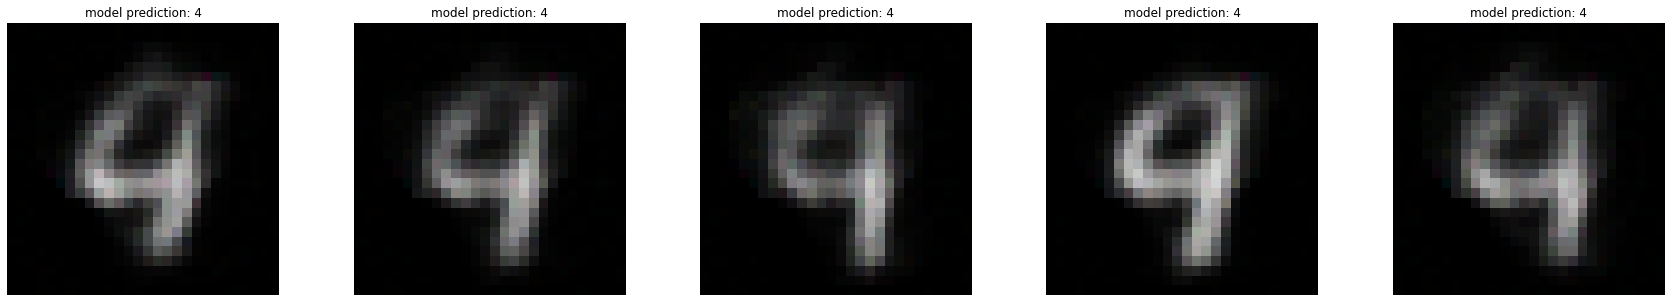

In [33]:
"""
Return the prototypes images
Arguments:
    num_prototypes: [5] number of prototypes to return
    return_latent: [False] if True return latent representation
    return_diff: [False] If True return the difference with the query image
    features: [None] list of the features int he latent space to use, if none use all
"""
proto = exp.getExemplars(num_prototypes=5)

F, ax = plt.subplots(1,5,figsize=(30,5))
for i in range(5):
    ax[i].imshow(proto[i]/255)
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(proto[i])[0]))

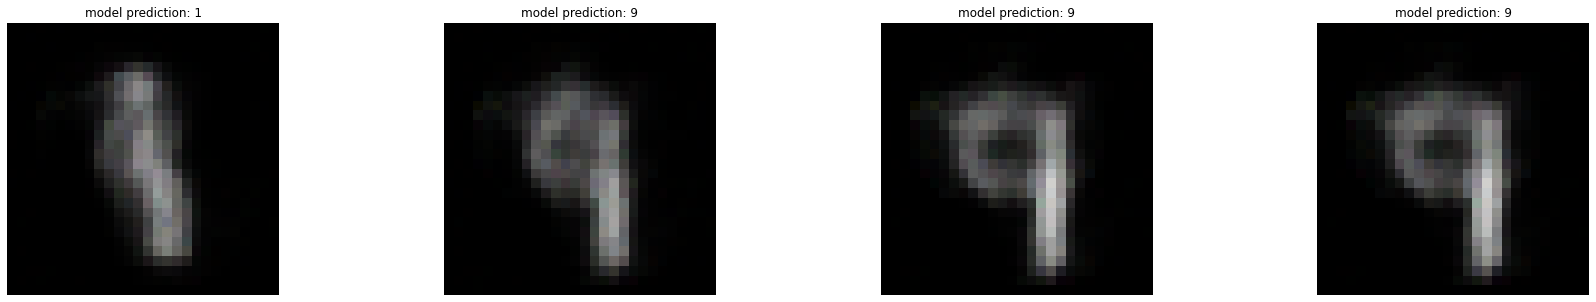

In [34]:
"""
Return the couterfactuals satisfying the counterfactual rule
"""
counter = exp.getCounterExemplars()

F, ax = plt.subplots(1,len(counter),figsize=(30,5))
for i in range(len(counter)):
    ax[i].imshow(counter[i]/255)
    ax[i].axis('off')
    ax[i].set_title('model prediction: '+str(bb_predict(counter[i])[0]))

# Metrics

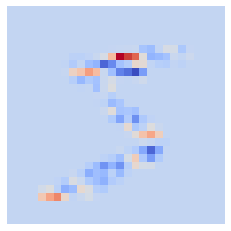

In [36]:
image = MNIST_x_data_train[0:1]
plt.imshow(tf_scores,cmap='coolwarm')
plt.axis(False);

In [42]:
from xailib.metrics.insertiondeletion import ImageInsDel
import torch

# Load the model
import tensorflow as tf
MNIST_CNN_tf = tf.keras.models.load_model('./models/keras_cnn_mnist')
MNIST_CNN_tf.trainable=False

def predict(image):
    return MNIST_CNN_tf.predict(image.reshape(1,28,28,1)/255) 

step = 28
mode = 'del'
metric = ImageInsDel(predict, mode, step, torch.zeros_like)

Score: 0.37589245502437874


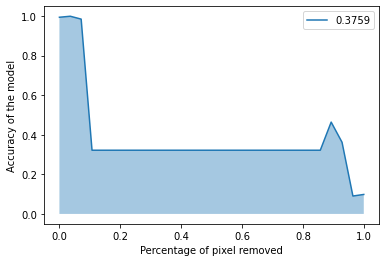

In [43]:
from sklearn.metrics import auc

y = metric(image, 28, tf_scores, rgb=False)
x = np.arange(len(y))*step/784
x[-1] = 1.0
print('Score:', auc(x, y))

plt.plot(x, y, label=np.round(auc(x, y),4))
plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

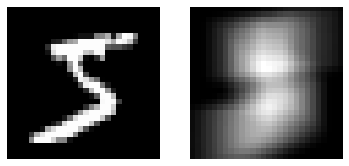

In [44]:
from scipy.ndimage.filters import gaussian_filter
CH = 1
def gkern(klen, nsig):
    """Returns a Gaussian kernel array.
    Convolution with it results in image blurring."""
    # create nxn zeros
    inp = np.zeros((klen, klen))
    # set element at the middle to one, a dirac delta
    inp[klen//2, klen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    k = gaussian_filter(inp, nsig)
    kern = np.zeros((CH, CH, klen, klen))
    for i in range(CH):
        kern[i, i] = k
    return torch.from_numpy(kern.astype('float32'))

# Function that blurs input image
def blur(image, klen=11, ksig=5):

    kern = gkern(klen, ksig)
    image = torch.tensor(np.expand_dims(image, 0)).float()
    return nn.functional.conv2d(image, kern, padding=klen//2)[0,:]

F,ax = plt.subplots(1,2)
ax[0].imshow(image[0,:], cmap='gray')
ax[0].axis(False)
ax[1].imshow(blur(image, 11, 5)[0,:],cmap='gray')
ax[1].axis(False);

In [45]:
from xailib.metrics.insertiondeletion import ImageInsDel

def predict(image):
    return MNIST_CNN_tf.predict(image.reshape(1,28,28,1)/255) 

step = 10
mode = 'ins'
metric = ImageInsDel(predict, mode, step, blur)

Score: 0.8813965625737852


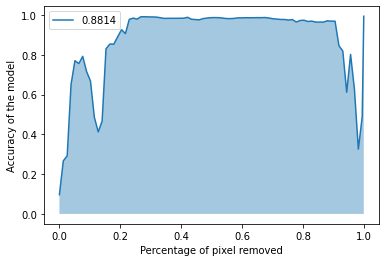

In [46]:
from sklearn.metrics import auc

y = metric(image, 28, scores, rgb=False)
x = np.arange(len(y))*step/784
x[-1] = 1.0
print('Score:', auc(x, y))

plt.plot(x, y, label=np.round(auc(x, y),4))
plt.fill_between(x, y, alpha=0.4)
plt.xlabel('Percentage of pixel removed')
plt.ylabel('Accuracy of the model')
plt.legend();

class 3: probability 0.108
class 1: probability 0.107


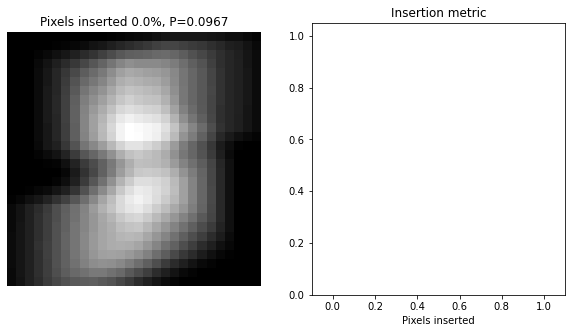

class 5: probability 0.267
class 9: probability 0.198


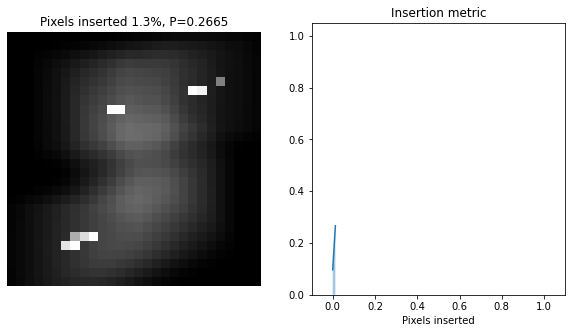

class 5: probability 0.292
class 9: probability 0.223


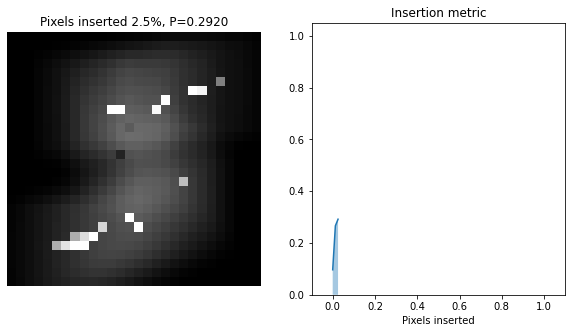

class 5: probability 0.651
class 9: probability 0.149


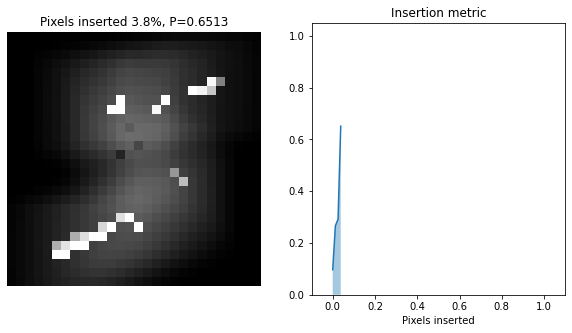

class 5: probability 0.770
class 3: probability 0.141


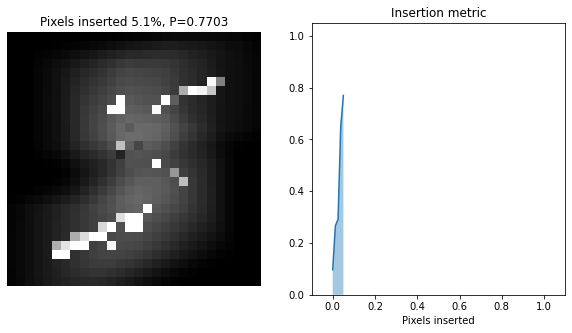

class 5: probability 0.756
class 3: probability 0.203


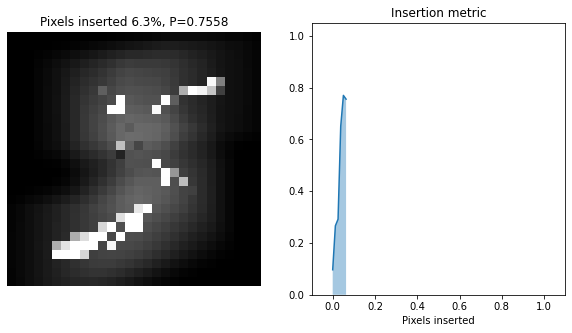

class 5: probability 0.792
class 3: probability 0.182


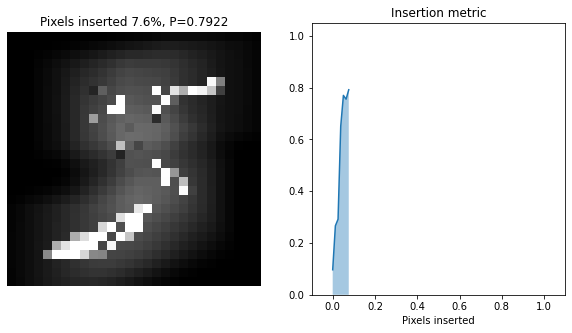

class 5: probability 0.715
class 3: probability 0.274


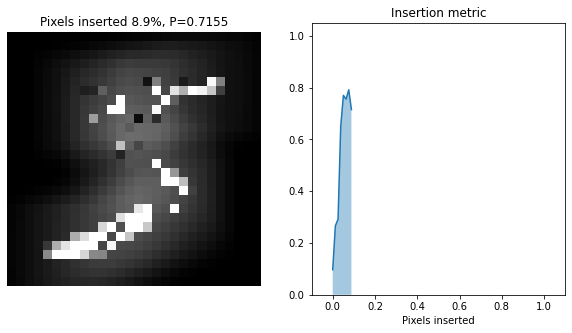

class 5: probability 0.668
class 3: probability 0.325


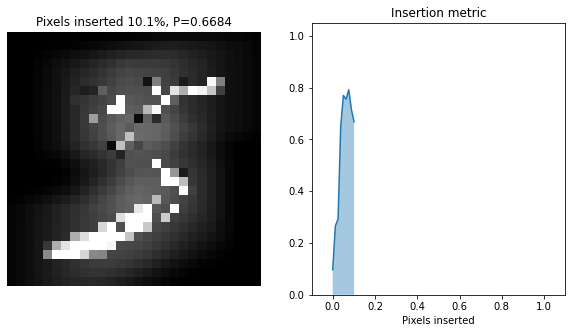

class 3: probability 0.507
class 5: probability 0.486


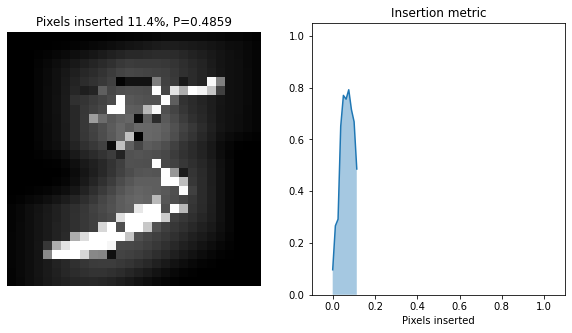

class 3: probability 0.580
class 5: probability 0.412


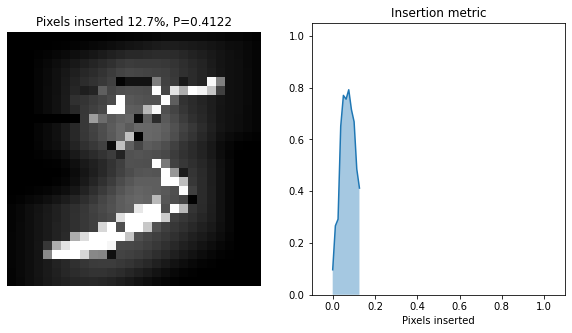

class 3: probability 0.525
class 5: probability 0.467


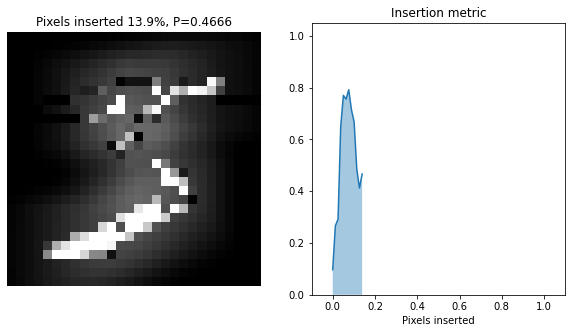

class 5: probability 0.830
class 3: probability 0.165


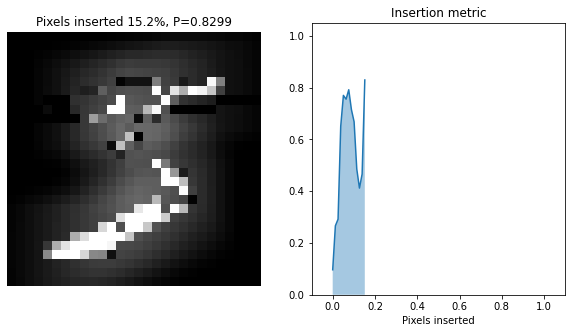

class 5: probability 0.854
class 3: probability 0.143


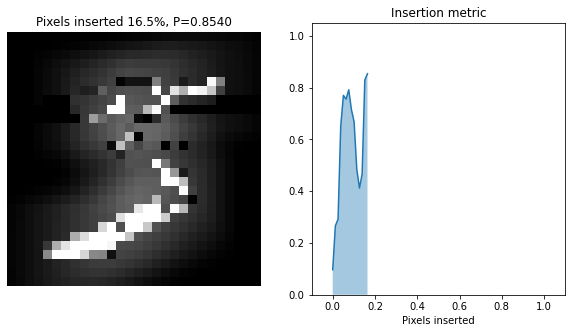

class 5: probability 0.853
class 3: probability 0.145


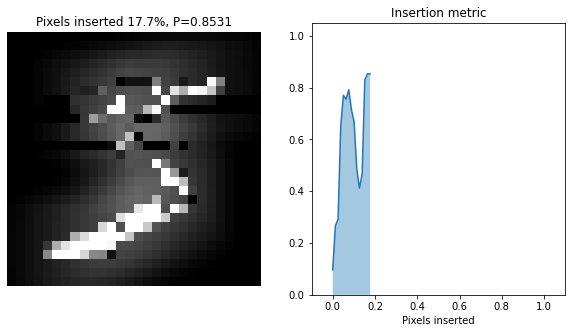

class 5: probability 0.890
class 3: probability 0.108


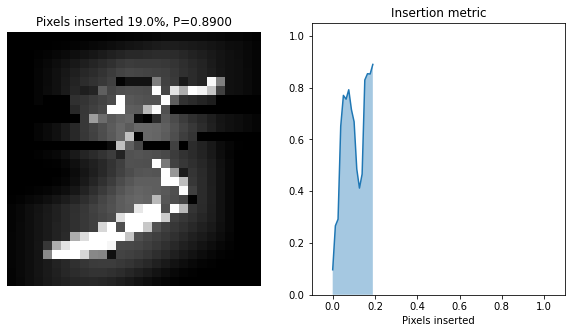

class 5: probability 0.926
class 3: probability 0.073


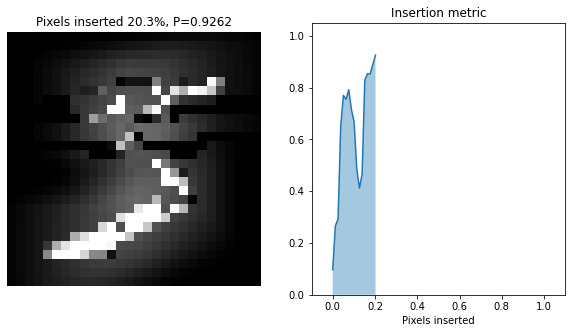

class 5: probability 0.906
class 3: probability 0.093


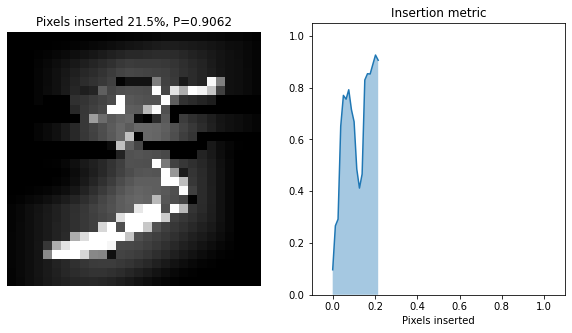

class 5: probability 0.978
class 3: probability 0.022


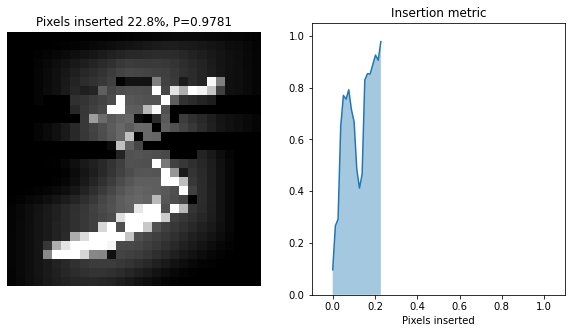

class 5: probability 0.984
class 3: probability 0.015


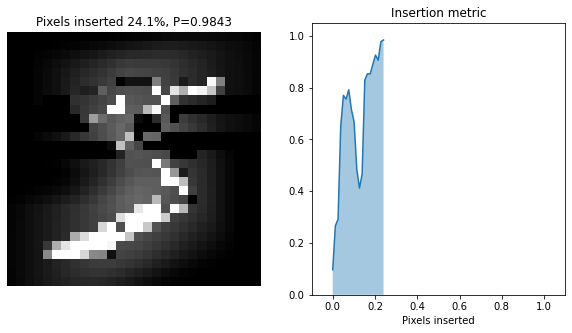

class 5: probability 0.979
class 3: probability 0.020


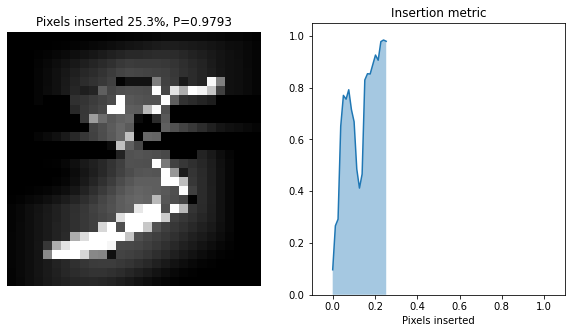

class 5: probability 0.991
class 3: probability 0.009


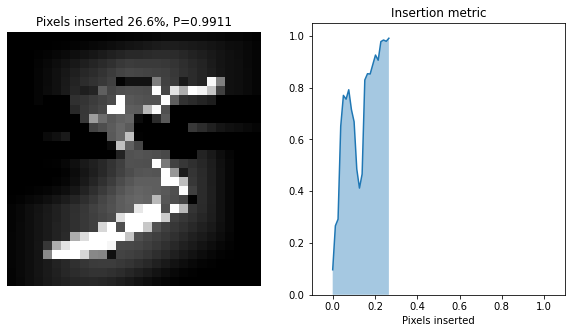

class 5: probability 0.991
class 3: probability 0.009


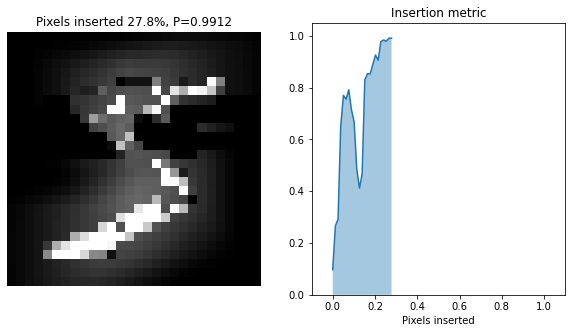

class 5: probability 0.990
class 3: probability 0.009


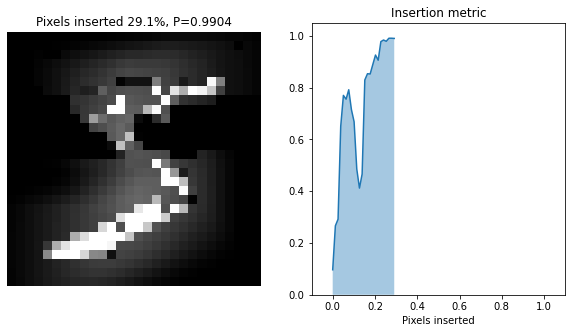

class 5: probability 0.990
class 3: probability 0.009


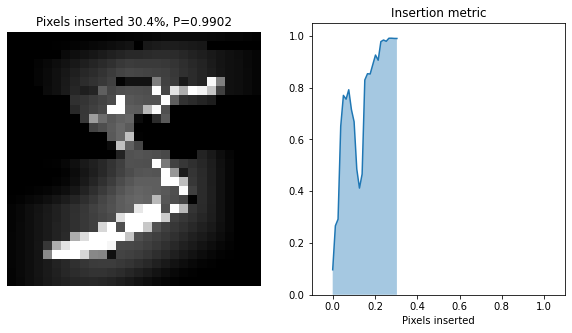

class 5: probability 0.989
class 3: probability 0.010


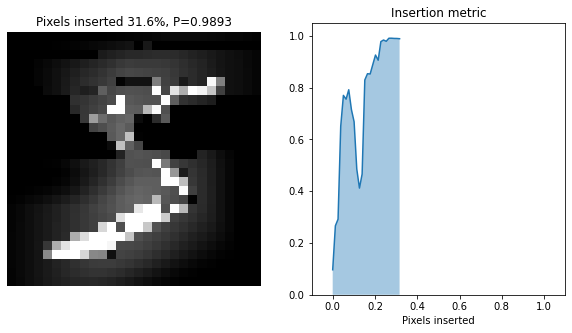

class 5: probability 0.986
class 3: probability 0.013


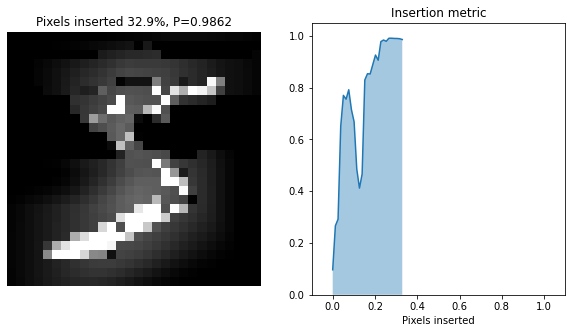

class 5: probability 0.983
class 3: probability 0.017


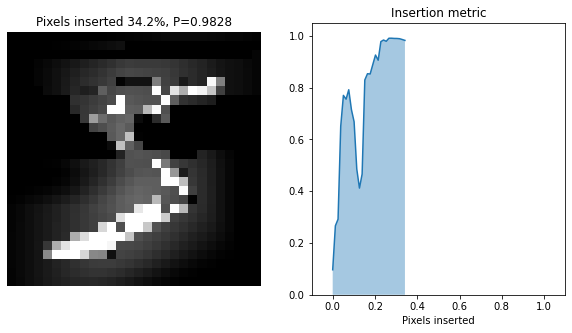

class 5: probability 0.983
class 3: probability 0.016


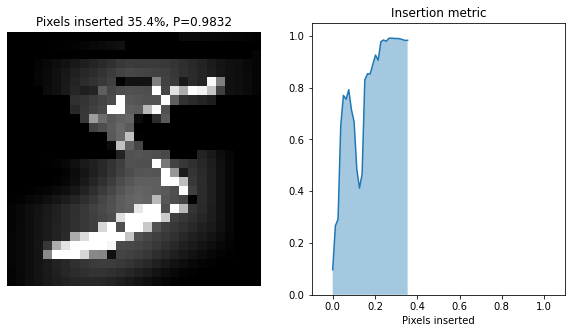

class 5: probability 0.983
class 3: probability 0.016


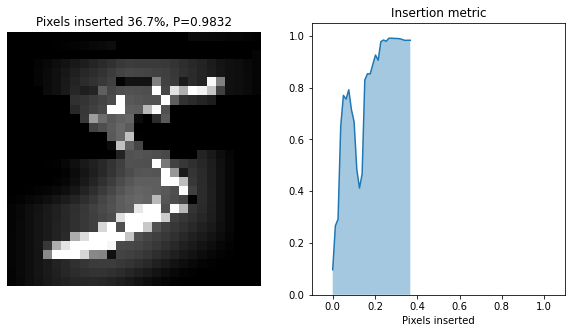

class 5: probability 0.983
class 3: probability 0.016


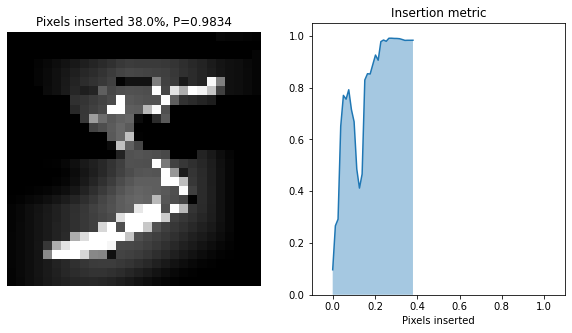

class 5: probability 0.983
class 3: probability 0.016


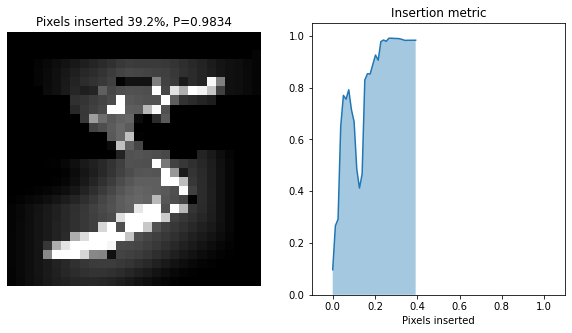

class 5: probability 0.984
class 3: probability 0.016


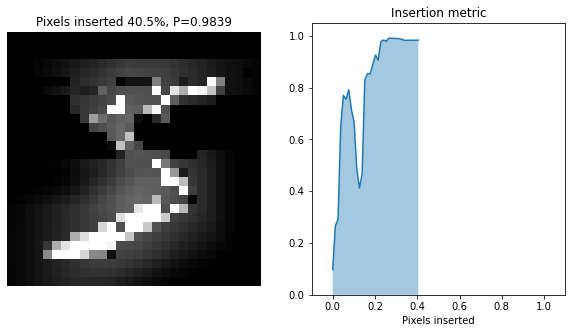

class 5: probability 0.988
class 3: probability 0.011


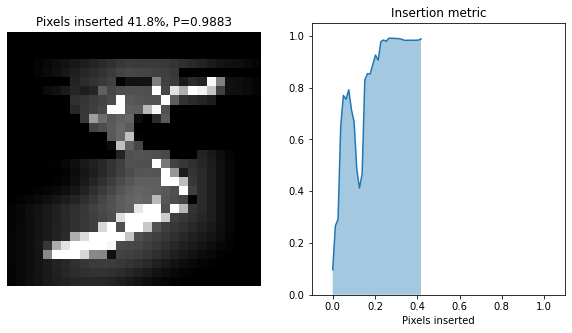

class 5: probability 0.979
class 3: probability 0.021


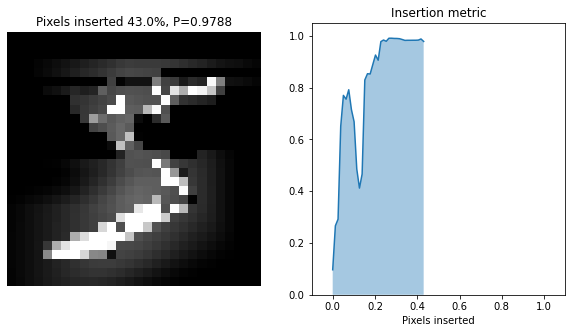

class 5: probability 0.977
class 3: probability 0.022


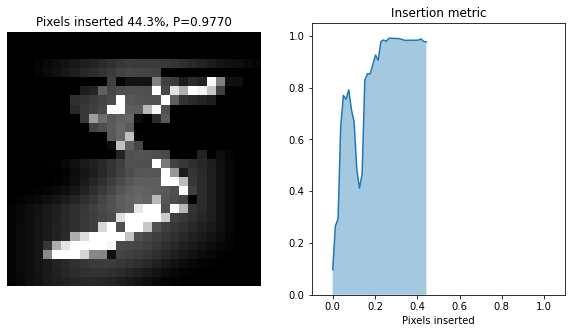

class 5: probability 0.976
class 3: probability 0.024


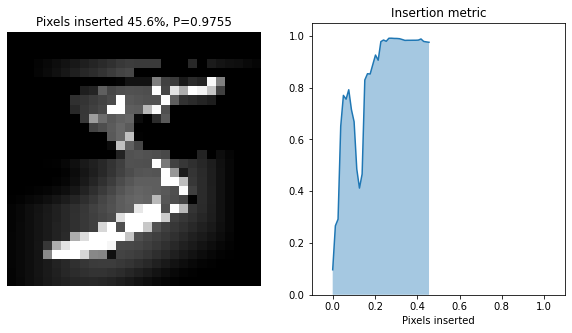

class 5: probability 0.982
class 3: probability 0.017


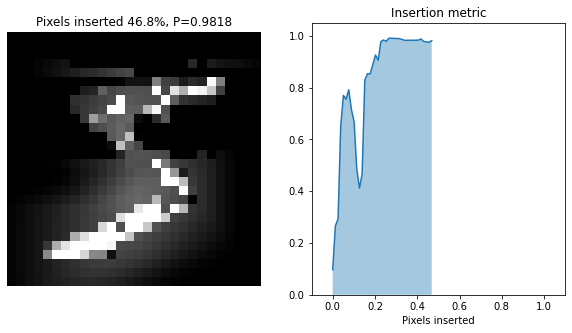

class 5: probability 0.984
class 3: probability 0.014


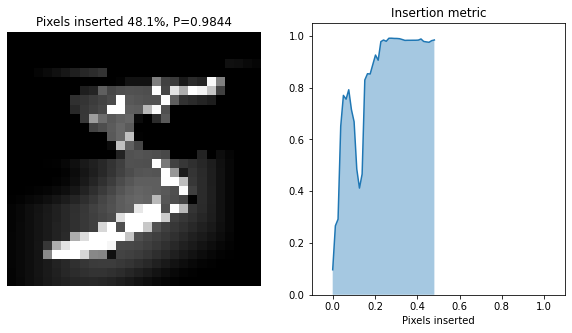

class 5: probability 0.987
class 3: probability 0.012


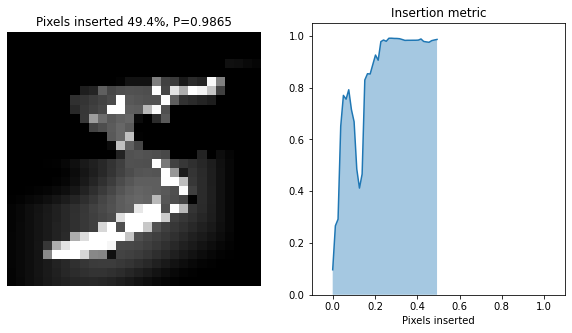

class 5: probability 0.987
class 3: probability 0.012


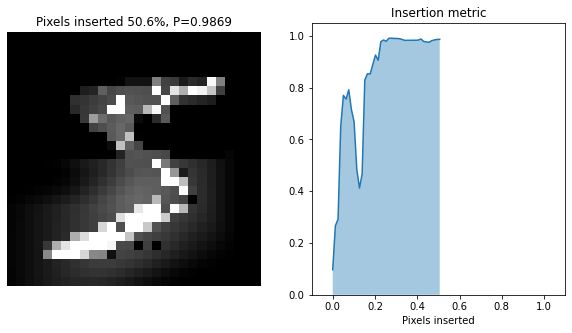

class 5: probability 0.987
class 3: probability 0.012


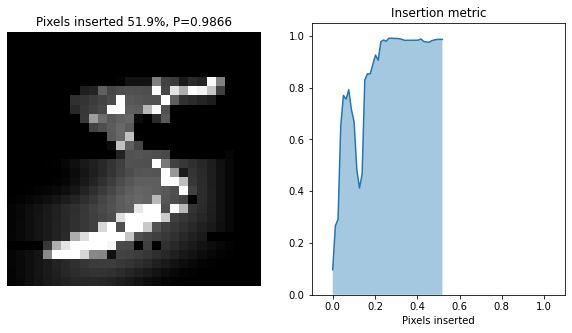

class 5: probability 0.985
class 3: probability 0.014


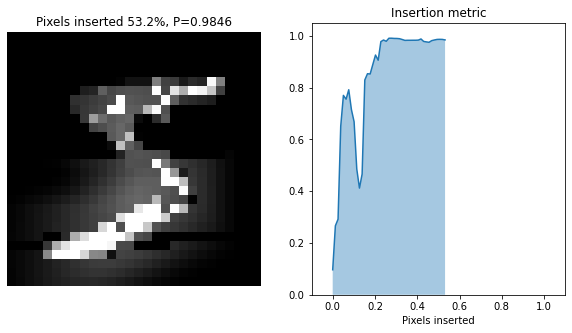

class 5: probability 0.982
class 3: probability 0.016


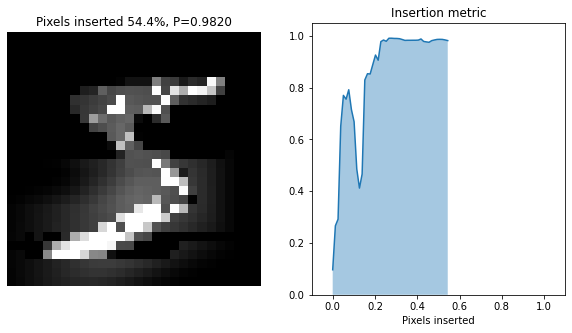

class 5: probability 0.982
class 3: probability 0.017


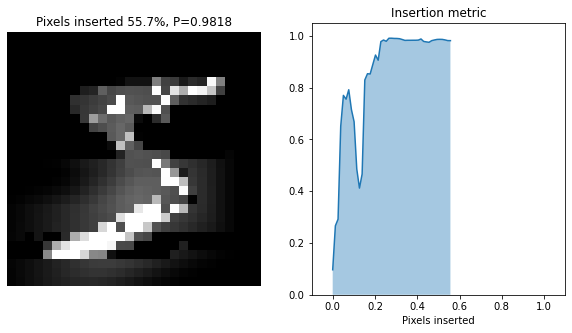

class 5: probability 0.983
class 3: probability 0.016


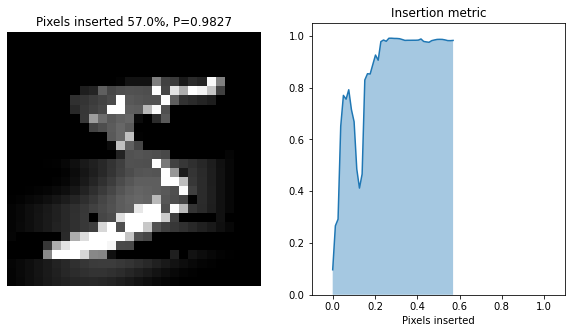

class 5: probability 0.986
class 3: probability 0.013


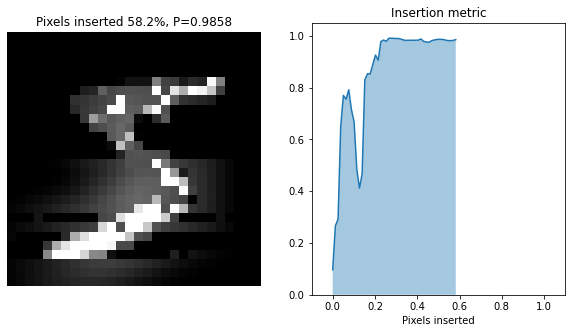

class 5: probability 0.986
class 3: probability 0.014


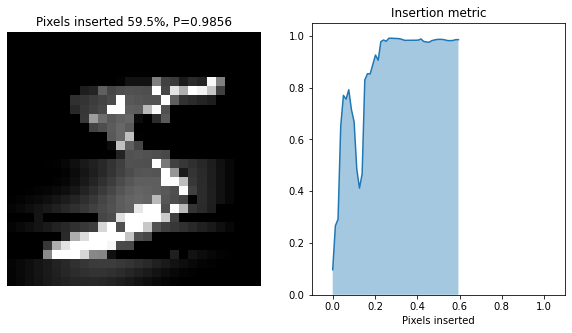

class 5: probability 0.986
class 3: probability 0.013


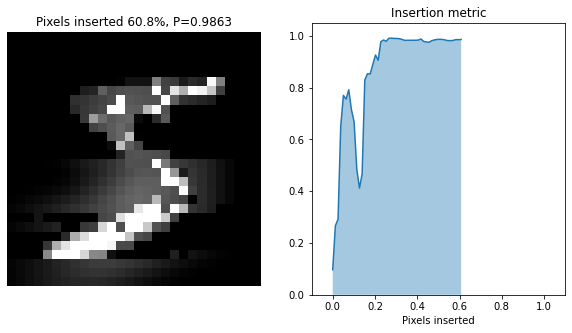

class 5: probability 0.986
class 3: probability 0.013


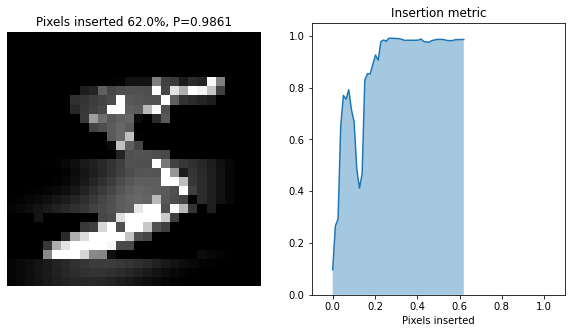

class 5: probability 0.986
class 3: probability 0.013


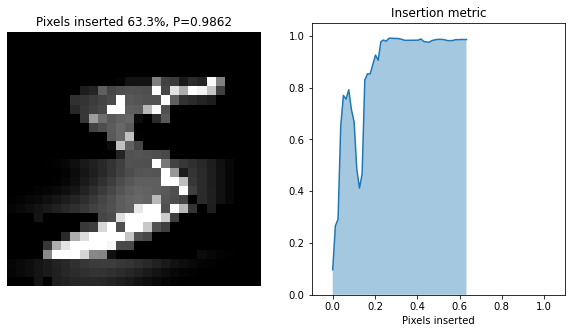

class 5: probability 0.987
class 3: probability 0.013


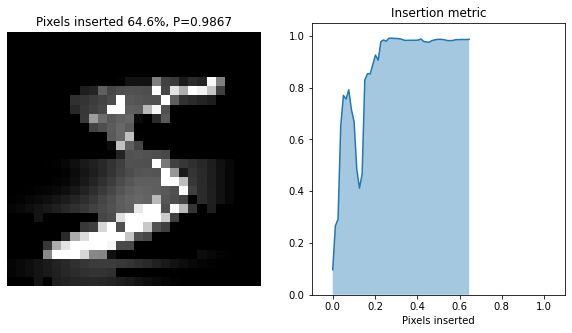

class 5: probability 0.987
class 3: probability 0.013


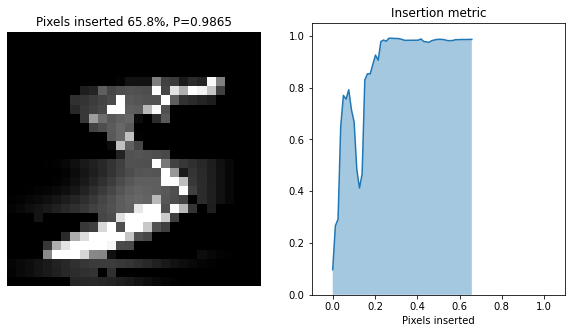

class 5: probability 0.987
class 3: probability 0.012


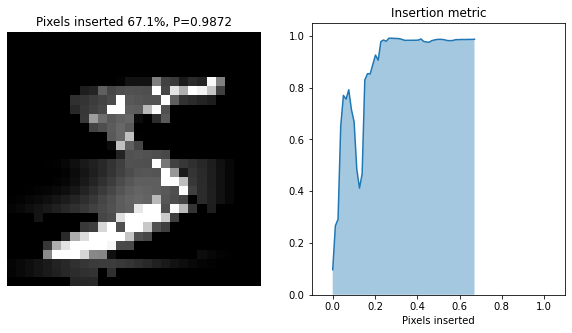

class 5: probability 0.985
class 3: probability 0.015


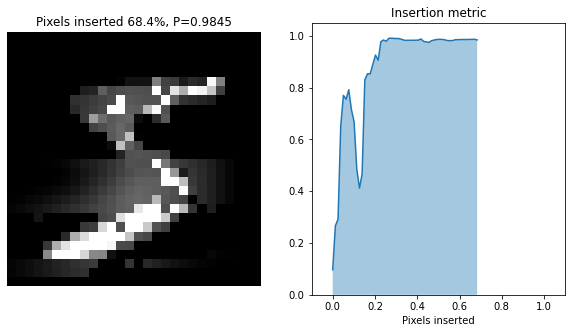

class 5: probability 0.981
class 3: probability 0.018


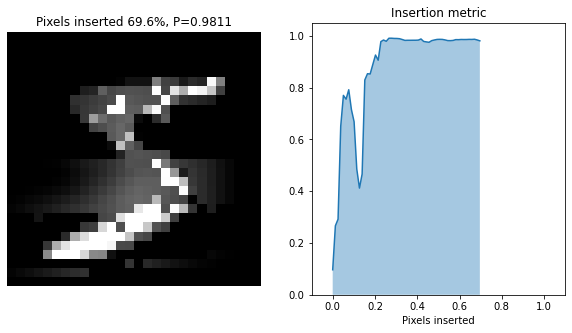

class 5: probability 0.979
class 3: probability 0.020


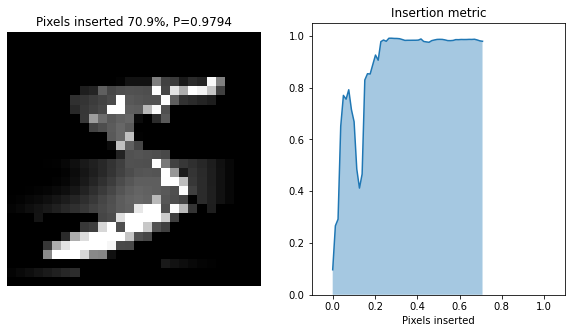

class 5: probability 0.978
class 3: probability 0.022


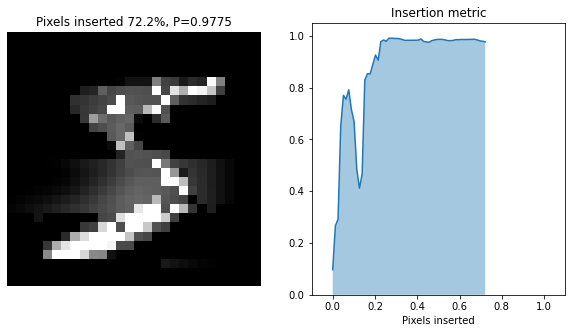

class 5: probability 0.977
class 3: probability 0.022


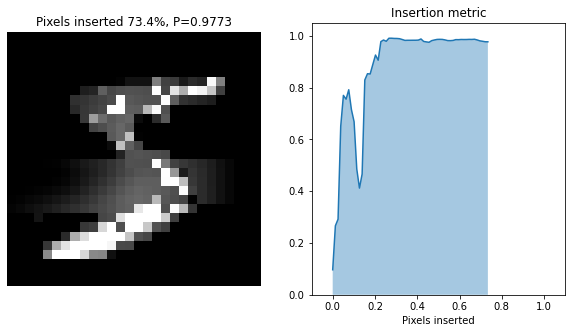

class 5: probability 0.975
class 3: probability 0.025


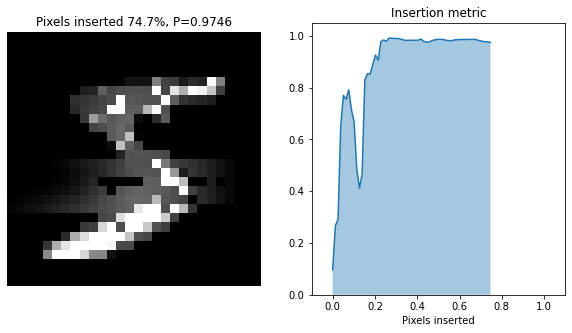

class 5: probability 0.977
class 3: probability 0.023


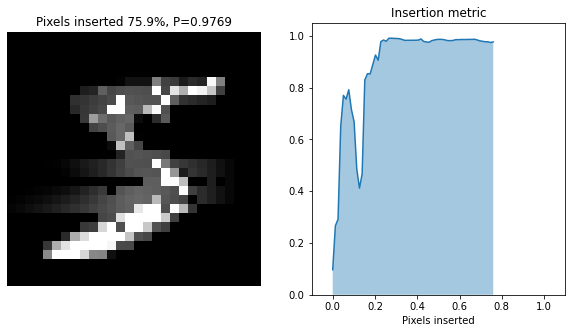

class 5: probability 0.965
class 3: probability 0.035


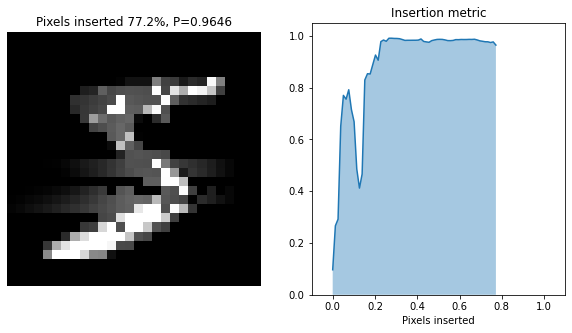

class 5: probability 0.972
class 3: probability 0.028


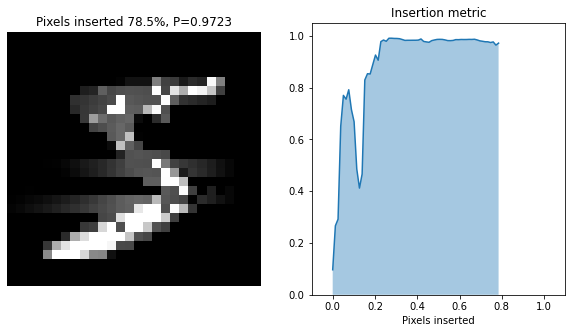

class 5: probability 0.974
class 3: probability 0.026


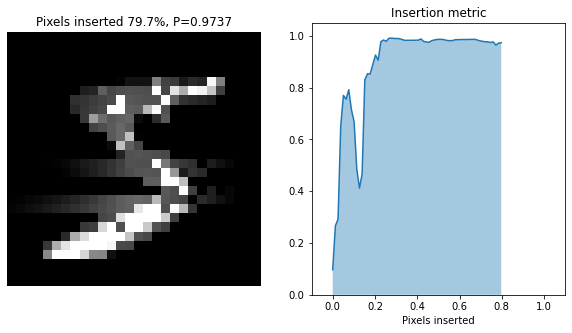

class 5: probability 0.967
class 3: probability 0.033


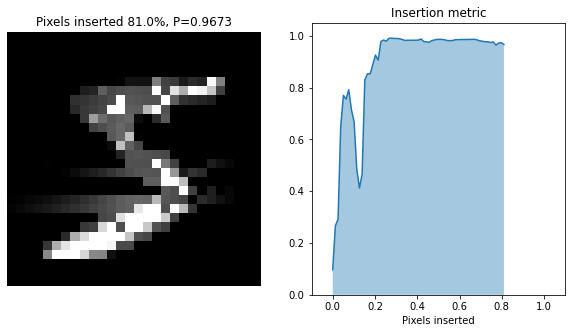

class 5: probability 0.969
class 3: probability 0.031


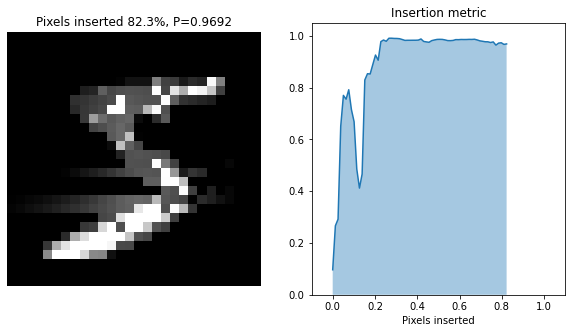

class 5: probability 0.964
class 3: probability 0.036


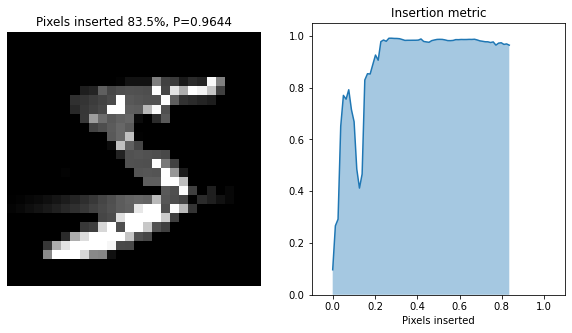

class 5: probability 0.964
class 3: probability 0.036


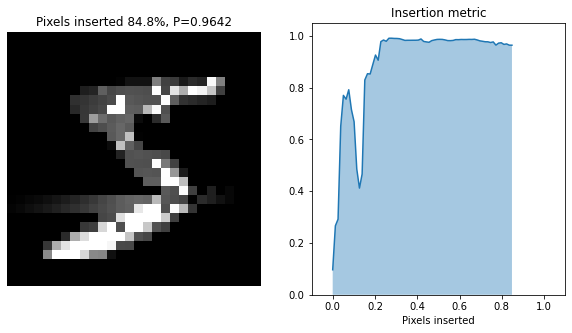

class 5: probability 0.964
class 3: probability 0.036


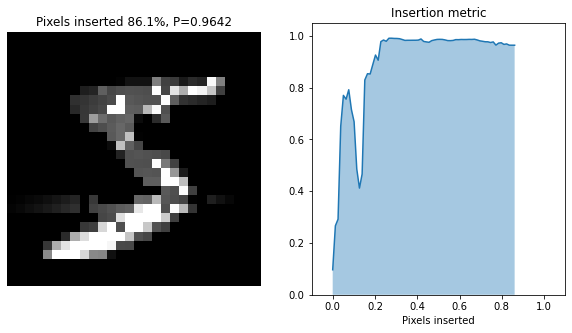

class 5: probability 0.971
class 3: probability 0.029


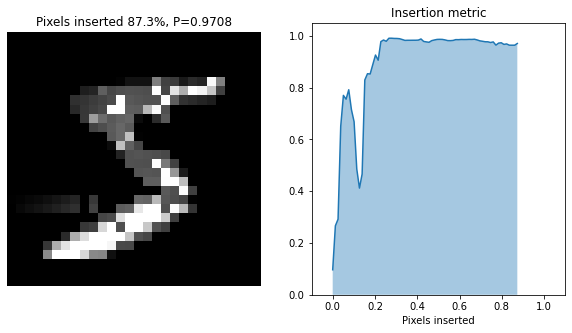

class 5: probability 0.969
class 3: probability 0.031


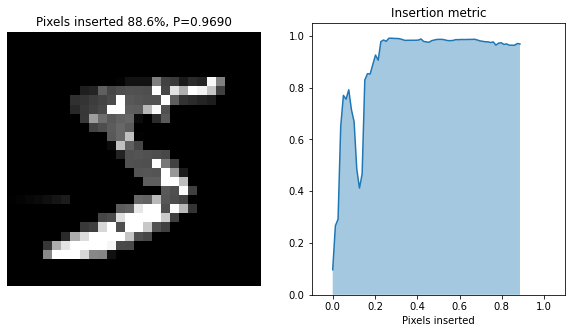

class 5: probability 0.969
class 3: probability 0.031


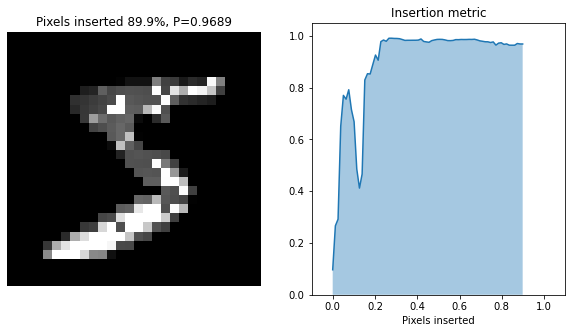

class 5: probability 0.846
class 3: probability 0.154


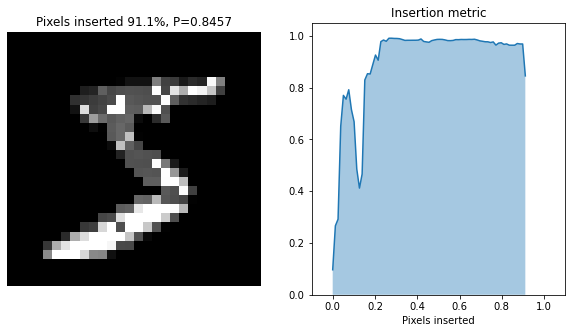

class 5: probability 0.819
class 3: probability 0.181


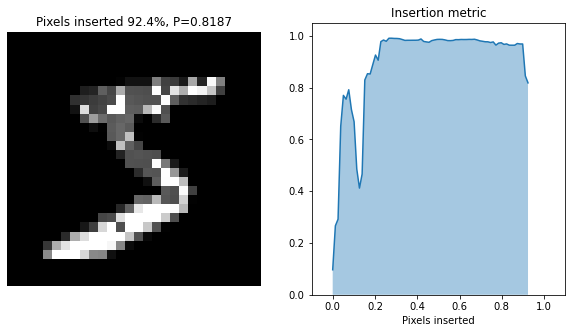

class 5: probability 0.611
class 3: probability 0.389


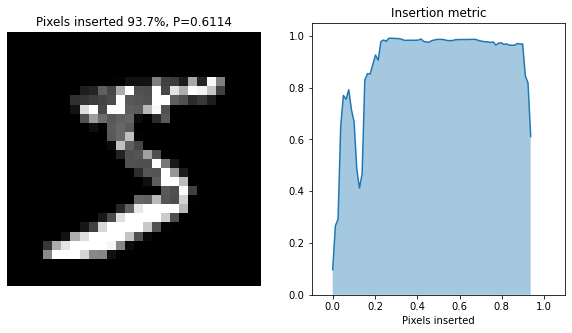

class 5: probability 0.802
class 3: probability 0.198


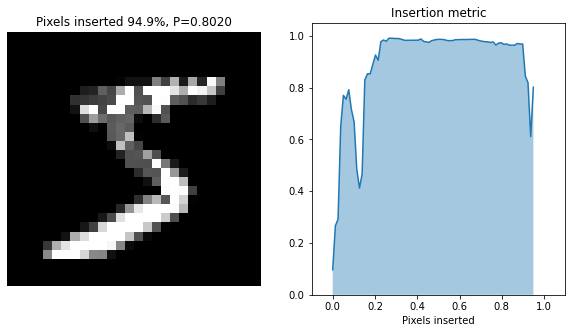

class 5: probability 0.625
class 3: probability 0.375


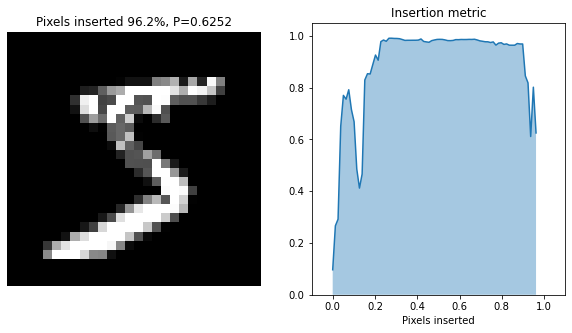

class 3: probability 0.674
class 5: probability 0.326


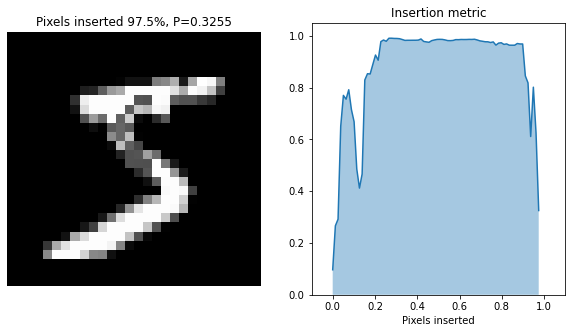

class 3: probability 0.511
class 5: probability 0.489


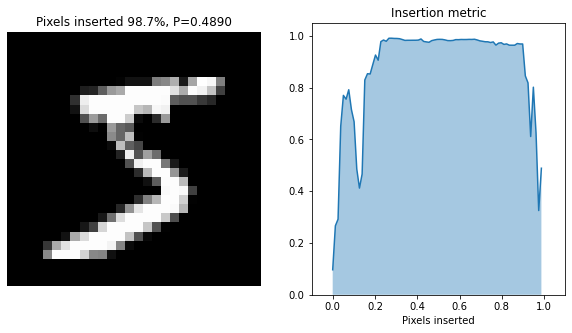

class 5: probability 0.994
class 3: probability 0.006


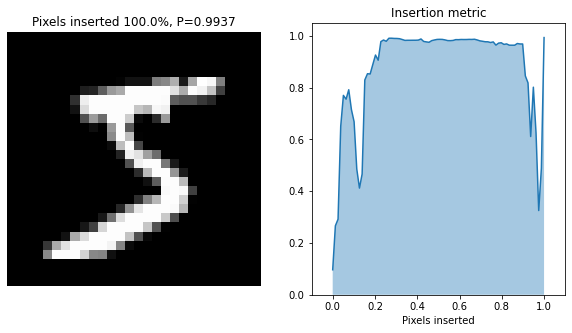

Score: 0.8813965625737852


In [47]:
y = metric(image, 28, scores, rgb=False, verbose=2)
print('Score:', auc(x, y))